This EDA notebook has the following structure:
1. Analysis of Individual Groups of Features
    1.1 Common Features
    1.2 Gene Expression Data
    1.3 Cell Viability Data
    1.4 Target Variable Data
2. Analysis of relationship between any 2 types of the data above

# GENERAL OVERVIEW OF DATA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import random
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.metrics import *
from scipy.stats import pearsonr
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [2]:
x = np.arange(10)
x = x.reshape(2,5)

x[:,-3:]

array([[2, 3, 4],
       [7, 8, 9]])

In [3]:
df_train = pd.read_csv('../input/lish-moa/train_features.csv')
df_test = pd.read_csv('../input/lish-moa/test_features.csv')
df_train_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
df_train_unscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

print(df_train.head())
print(df_train_scored.head())

         sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077 

Unscored data is used for context analysis, rather than to be predicted. Test features do not include unscored data.

In [4]:
# check For missing values 
df_train.isnull().sum().sum()

0

In [5]:
# check For missing values 
df_test.isnull().sum().sum()

0

In [6]:
# check for target sparsity
scored = df_train_scored.drop(columns = ["sig_id"] , axis = 1)
# non zero target varaibles
print((scored.to_numpy()).sum()/(scored.shape[0]*scored.shape[1])*100 , "%")

0.34335680814337 %


In [7]:
print("Shape of {}: {}".format("training data",df_train.shape))
print("Shape of {}: {}".format("target data",df_train_scored.shape))
print("Shape of {}: {}".format("testing data",df_test.shape))

Shape of training data: (23814, 876)
Shape of target data: (23814, 207)
Shape of testing data: (3982, 876)


In [8]:
df_train.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [9]:
df_train_unscored.describe()

,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.0,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.0,23814.000000,23814.000000,23814.000000,23814.0,23814.000000,23814.000000
mean,0.000252,0.001008,0.003821,0.000252,0.0,0.000084,0.000252,0.000504,0.000504,0.000252,...,0.000252,0.000504,0.000756,0.0,0.001050,0.000756,0.000252,0.0,0.001008,0.001008
std,0.015871,0.031731,0.061700,0.015871,0.0,0.009164,0.015871,0.022443,0.022443,0.015871,...,0.015871,0.022443,0.027483,0.0,0.032384,0.027483,0.015871,0.0,0.031731,0.031731
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [10]:
df_train_scored.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.000714,0.000756,0.001008,0.007979,0.012640,0.003065,0.002268,0.004031,0.000504,0.011338,...,0.000252,0.001050,0.002016,0.013270,0.003065,0.000252,0.007139,0.001092,0.001638,0.001260
std,0.026709,0.027483,0.031731,0.088967,0.111716,0.055283,0.047566,0.063365,0.022443,0.105876,...,0.015871,0.032384,0.044851,0.114429,0.055283,0.015871,0.084190,0.033025,0.040436,0.035472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 1.1 COMMON FEATURES ANALYSIS


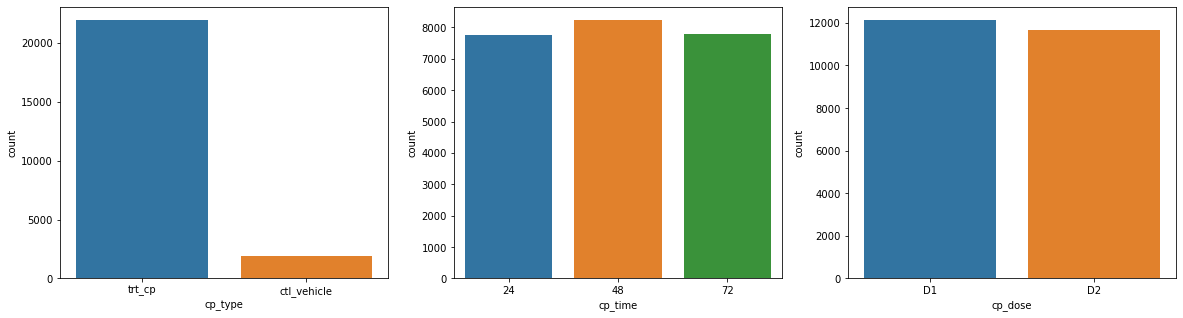

In [11]:
plt.rcParams['figure.figsize']=(20,5)
fig, ax = plt.subplots(1,3)
sns.countplot(df_train["cp_type"], ax = ax[0])
sns.countplot(df_train["cp_time"], ax= ax[1])
sns.countplot(df_train["cp_dose"], ax = ax[2])


Controls (denoted by ctl_vehicle) have no MoA. Treatment time is fairly evenly distributed into values 24/48/72 hours. Treatment dose has 2 values, D1 and D2.

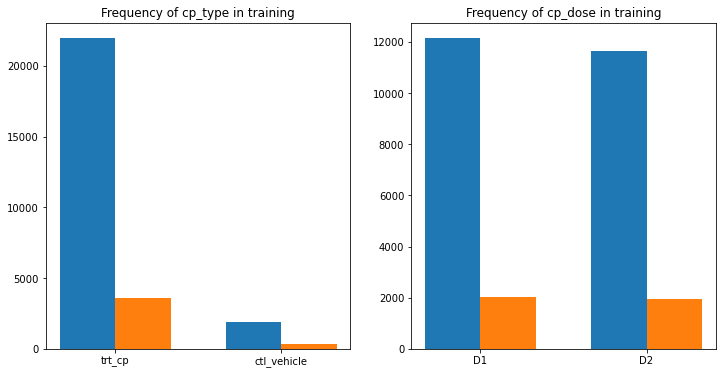

In [12]:
fig, (cp_type_bar, cp_dose_bar) = plt.subplots(nrows=1, ncols=2, figsize=[12, 6])

# plot frequency of cp_type
cp_type_training_count = df_train['cp_type'].value_counts()
cp_type_test_count = df_test['cp_type'].value_counts()
cp_type_label = cp_type_training_count.index
cp_type_width = 1.0
cp_type_bar.bar([0, 3], cp_type_training_count, width=cp_type_width)
cp_type_bar.bar([1, 4], cp_type_test_count, width=cp_type_width)
cp_type_bar.set_xticks([0.5, 3.5])
cp_type_bar.set_xticklabels(cp_type_label)
cp_type_bar.set_title('Frequency of cp_type in training')

# plot frequency of cp_dose
cp_dose_training_count = df_train['cp_dose'].value_counts()
cp_dose_test_count = df_test['cp_dose'].value_counts()
cp_dose_label = cp_dose_training_count.index
cp_dose_width = 1.0
cp_dose_bar.bar([0, 3], cp_dose_training_count, width = cp_dose_width)
cp_dose_bar.bar([1, 4], cp_dose_test_count, width = cp_dose_width)
cp_dose_bar.set_xticks([0.5, 3.5])
cp_dose_bar.set_xticklabels(cp_dose_label)
cp_dose_bar.set_title('Frequency of cp_dose in training')

plt.show()

Controls (denoted by ctl_vehicle) have no MoA. Treatment time is fairly evenly distributed into values 24/48/72 hours. Treatment dose has 2 values, D1 and D2.

In [13]:
df_train_full = pd.merge(df_train_scored,df_train_unscored,on = "sig_id", how = 'inner')
df_train_full

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# list the columns 
# list(features)
# get all the gene features and cell features
common  = ['sig_id',
 'cp_type',
 'cp_time',
 'cp_dose']


genes = list(filter(lambda x : "g-" in x  , list(df_train)))

cells = list(filter(lambda x : "c-" in x  , list(df_train)))

# 1.2 **GENE EXPRESSION FEATURES**

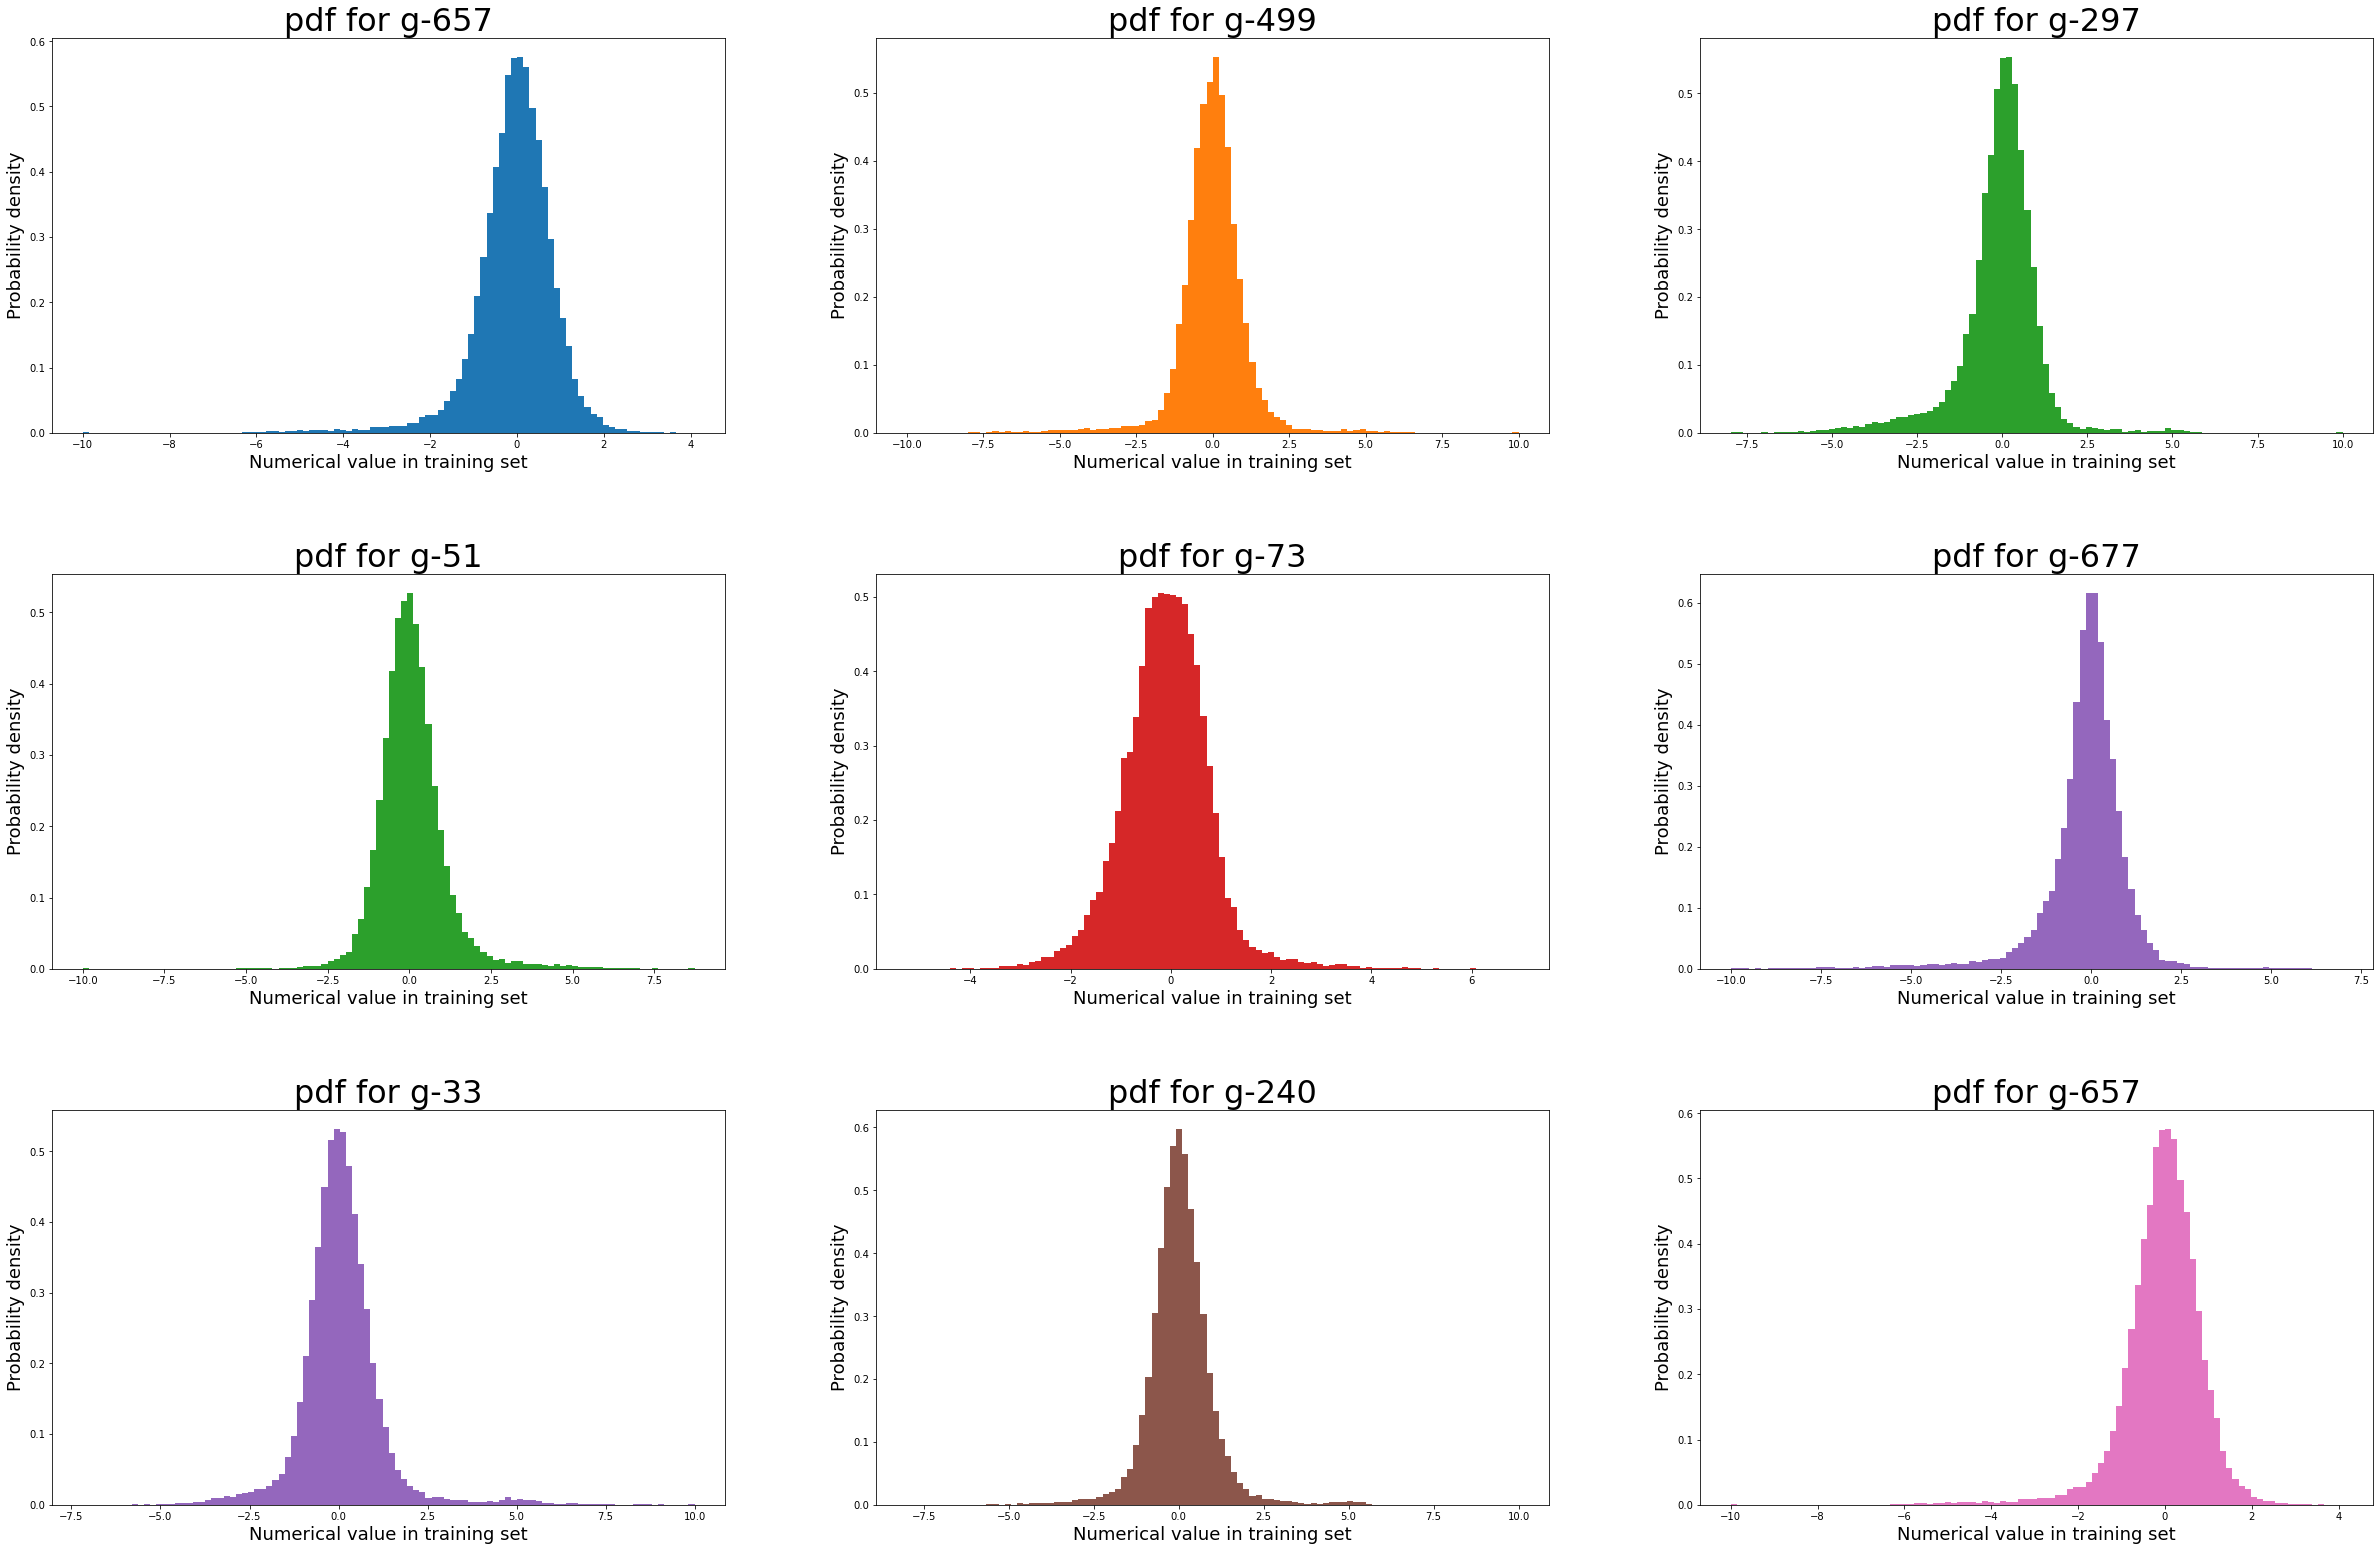

In [15]:
#Taking a look at the distribution for some genes
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[36,24])
fig.tight_layout(pad=12.0)
cmap = plt.cm.get_cmap("tab10")
colors = cmap.colors
# plot pdf for 9 random g- features
for i in range(nrows):
    for j in range(ncols):
        feature = random.randint(0, 771)
        axis = ax[i][j]
        axis.hist(df_train[f'g-{feature}'], bins=100, density=True, color=colors[2 * i + j])
        axis.set_title(f'pdf for g-{feature}', {'fontsize': 32})
        axis.set_xlabel("Numerical value in training set", {'fontsize': 18})
        axis.set_ylabel("Probability density", {'fontsize': 18})

plt.show()

Distibutions look approximately normal. However, distribution for some genes are skewed, as shown below.

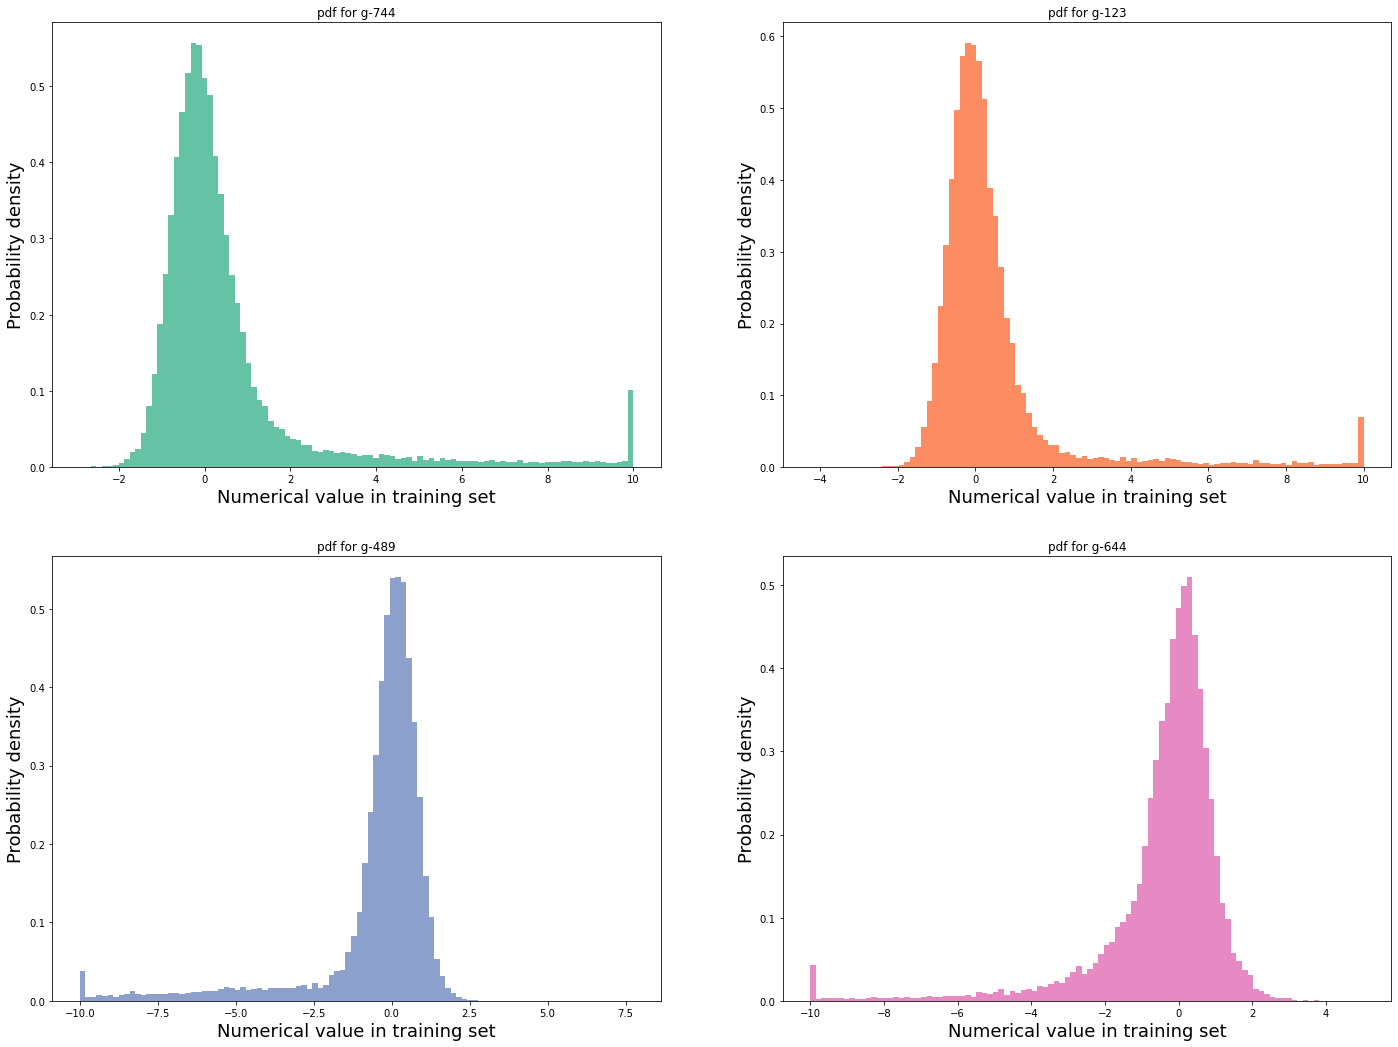

In [16]:
# Some slightly skewed data for features in g
nrows, ncols = 2, 2
fig, ax = plt.subplots(figsize=[24, 18], nrows=nrows, ncols=ncols)
skewed_g = [['g-744', 'g-123'], ['g-489', 'g-644']]
cmap = plt.cm.get_cmap("Set2")
colors = cmap.colors
for i in range(nrows):
    for j in range(ncols):
        axis = ax[i][j]
        axis.hist(df_train[skewed_g[i][j]], bins=100, density=True, color=colors[2 * i + j])
        axis.set_title(f'pdf for {skewed_g[i][j]}')
        axis.set_xlabel("Numerical value in training set", {'fontsize': 18})
        axis.set_ylabel("Probability density", {'fontsize': 18})
plt.show()
#g-744,g-123 g-489, g-644g-23, #g-644, g-413, g-307, g-238

However, we can see some slight skew in the gene data.

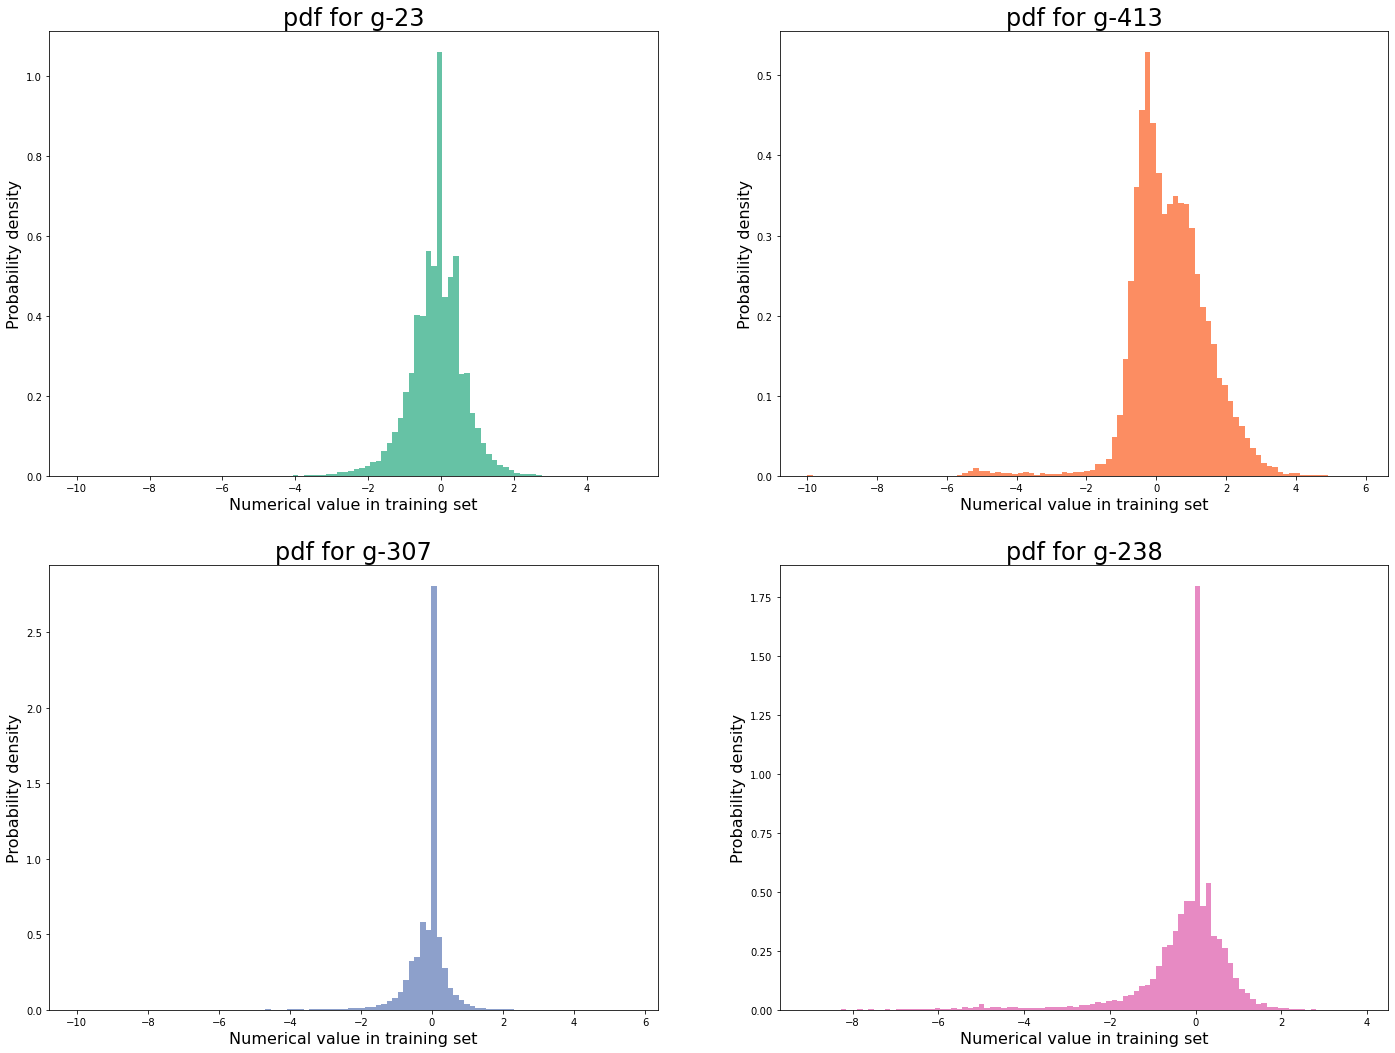

In [17]:
# More slightly skewed data for features in g
nrows, ncols = 2, 2
fig, ax = plt.subplots(figsize=[24, 18], nrows=nrows, ncols=ncols)
skewed_g = [['g-23', 'g-413'], ['g-307', 'g-238']]
cmap = plt.cm.get_cmap("Set2")
colors = cmap.colors
for i in range(nrows):
    for j in range(ncols):
        axis = ax[i][j]
        axis.hist(df_train[skewed_g[i][j]], bins=100, density=True, color=colors[2 * i + j])
        axis.set_title(f'pdf for {skewed_g[i][j]}', {'fontsize': 24})
        axis.set_xlabel("Numerical value in training set", {'fontsize': 16})
        axis.set_ylabel("Probability density", {'fontsize': 16})
plt.show()

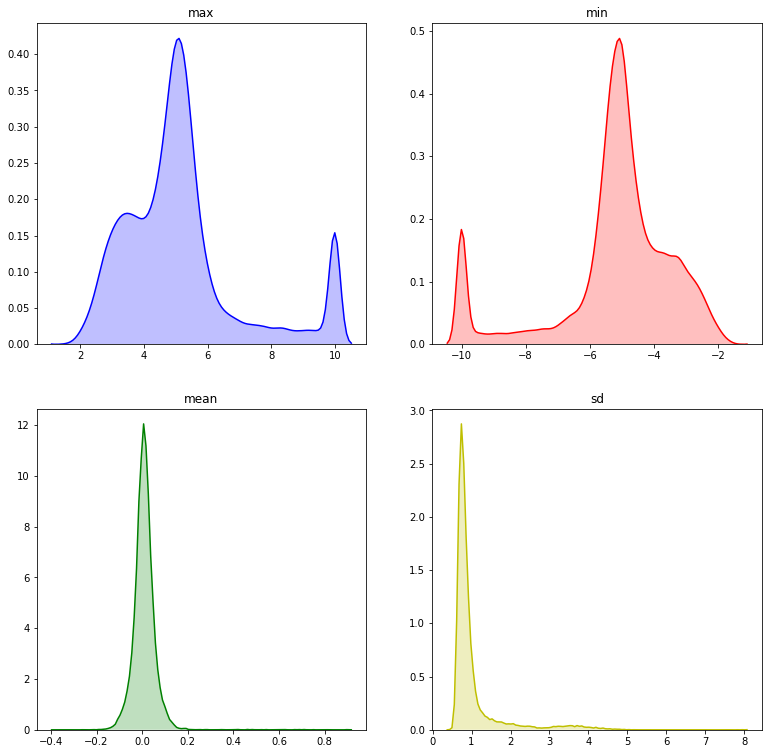

In [18]:
# some stats plot for genes. Find distribution of max/min/mean/std across all gene columns.
fig, axs = plt.subplots(ncols=2 , nrows = 2 , figsize=(13,13))
sns.distplot(df_train[genes].max(axis =1) ,color="b",hist=False, kde_kws={"shade": True}, ax=axs[0][0] ).set(title = 'max')
sns.distplot(df_train[genes].min(axis =1) ,color="r",hist=False, kde_kws={"shade": True}, ax=axs[0][1] ).set(title = 'min')
sns.distplot(df_train[genes].mean(axis =1), color="g",hist=False, kde_kws={"shade": True}, ax=axs[1][0] ).set(title = 'mean')
sns.distplot(df_train[genes].std(axis =1) ,color="y",hist=False, kde_kws={"shade": True}, ax=axs[1][1] ).set(title = 'sd')
plt.show()

1. The means are pretty nicely distributed around zero
2. standard deviations chiefly between 0.5 and 1.5.
3. The min and max are a nice mirror image of each other.
4. There are notable increases around the range of positive/negative 9 - 10(min and max respectively)

BJ's notebook also includes the following analysis for g-307, although i'm not sure what the reason behind examining this particular gene is.

# 1.3 CELL VIABILITY FEATURES

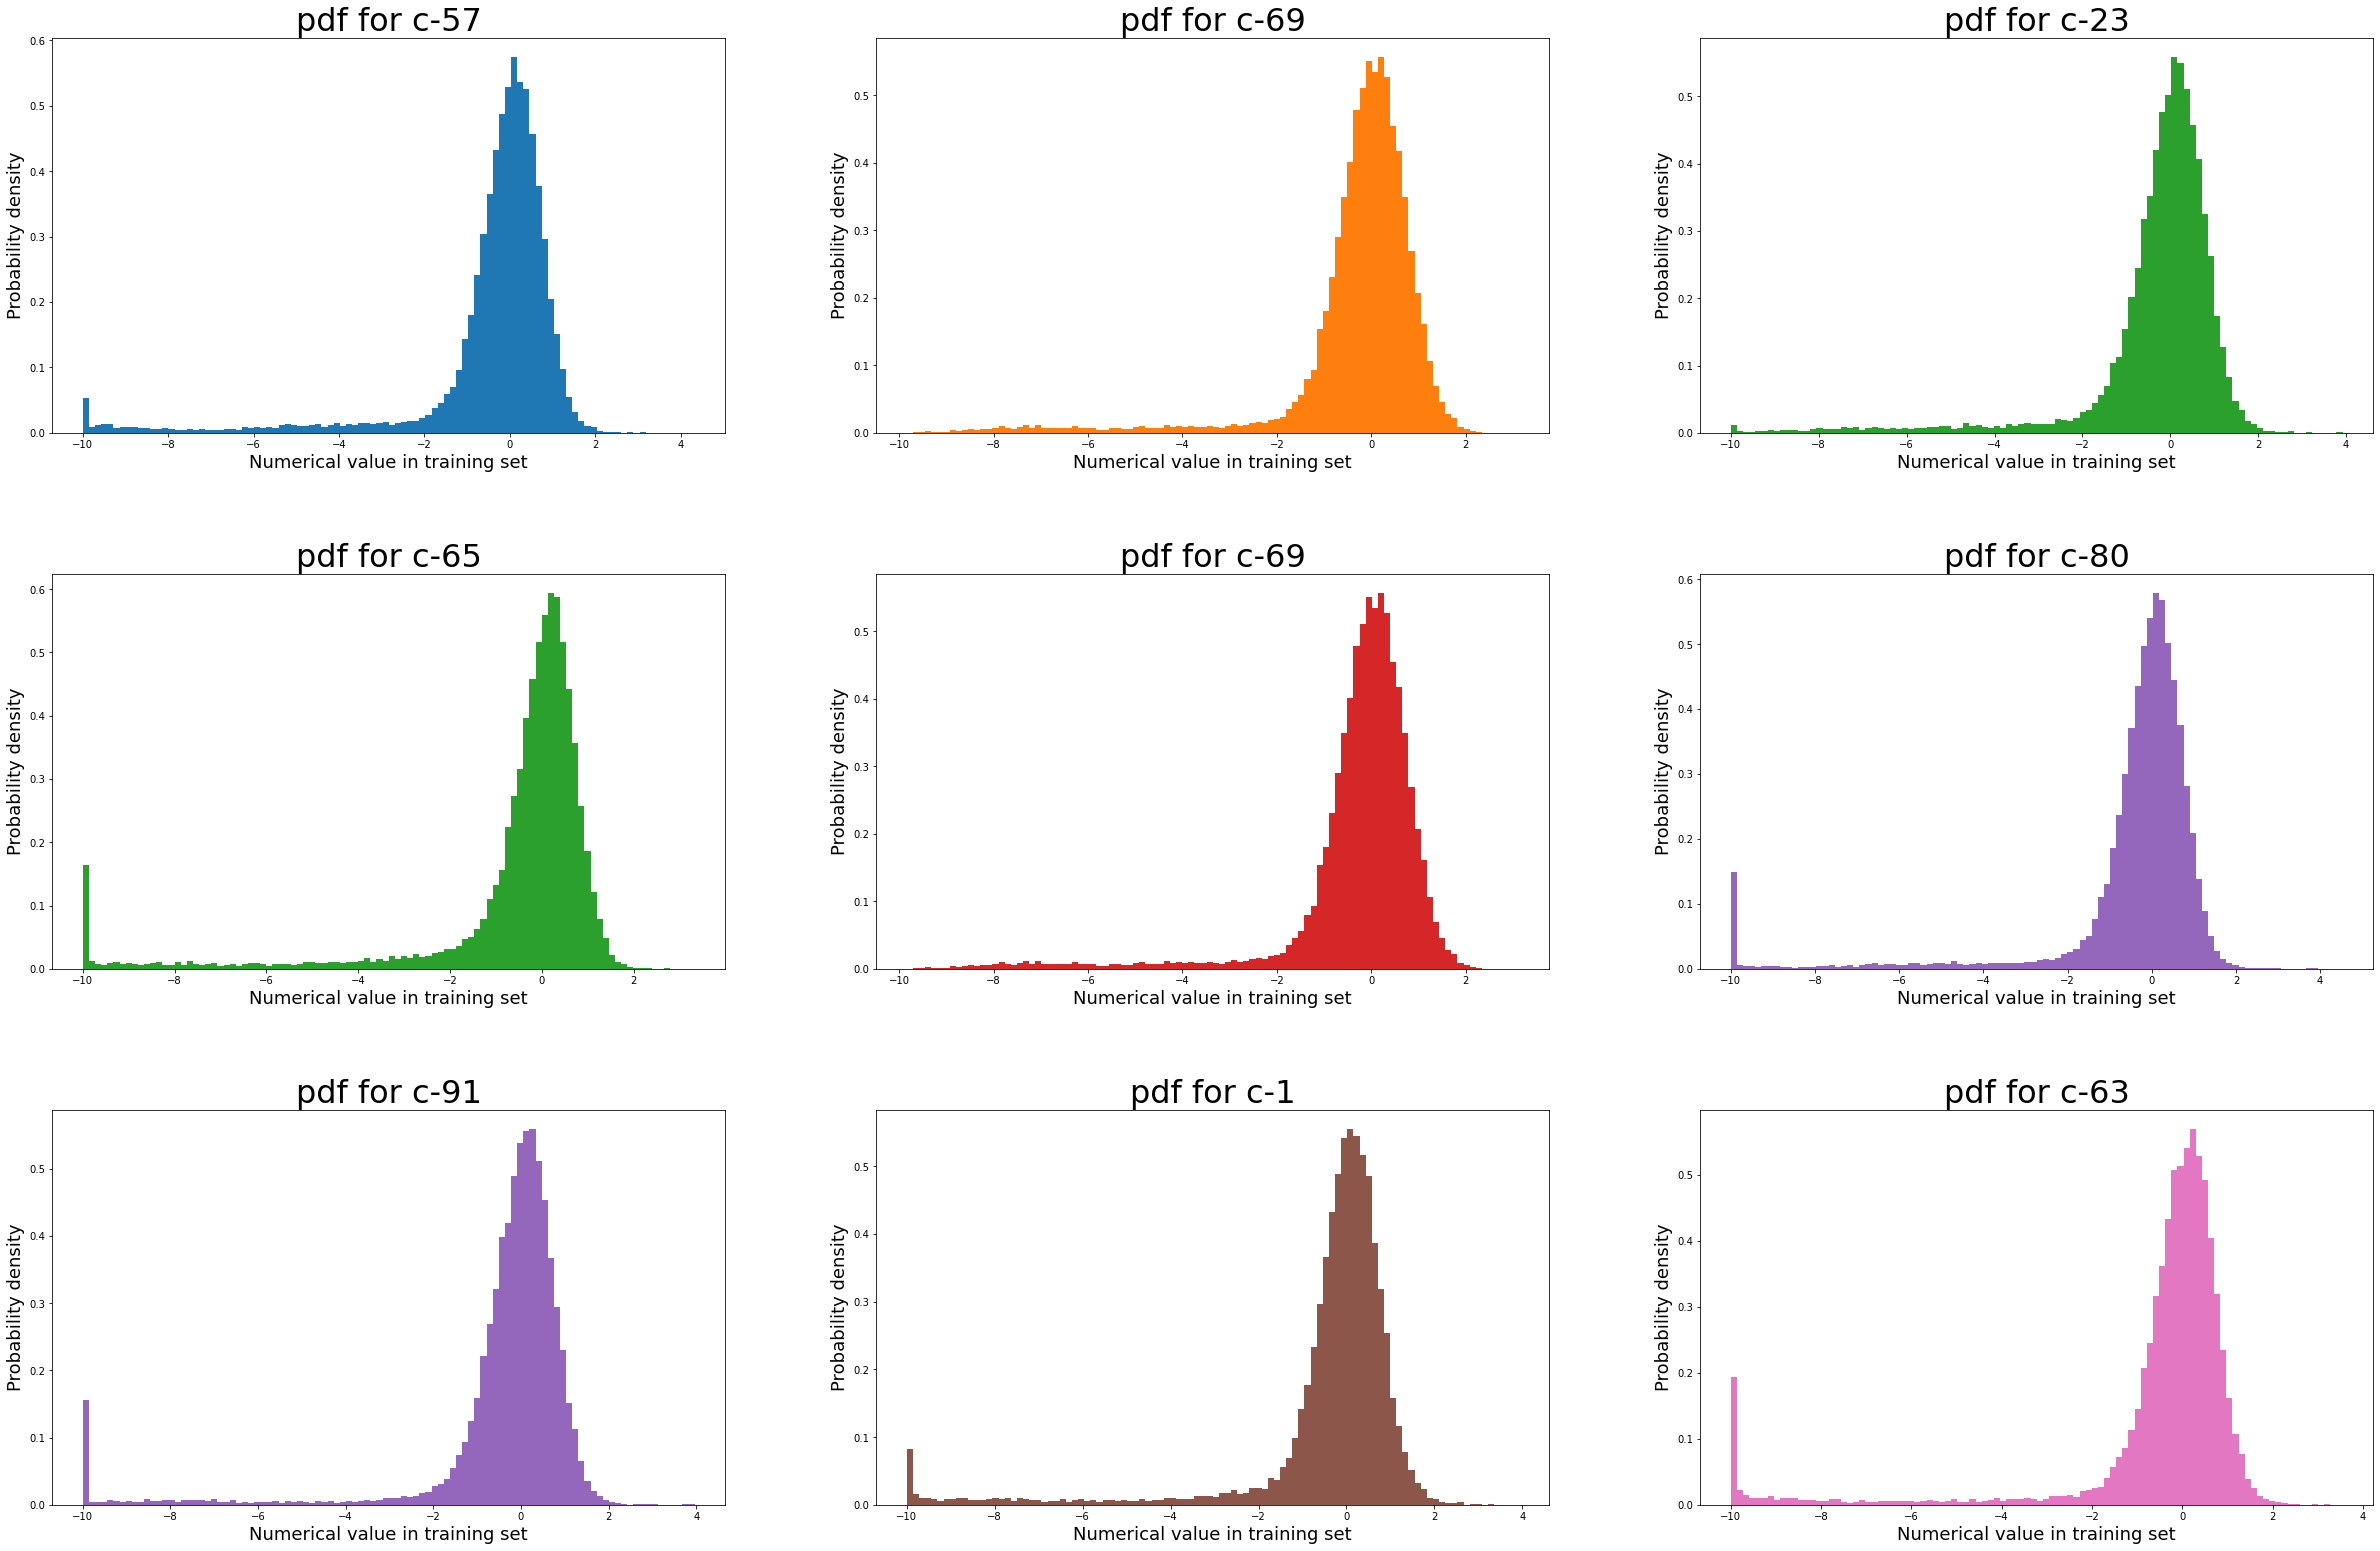

In [19]:
#show histogram plots for randomly chosen cells
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[36,24])
fig.tight_layout(pad=12.0)
cmap = plt.cm.get_cmap("tab10")
colors=cmap.colors
# plot pdf for 9 random c- features
for i in range(nrows):
    for j in range(ncols):
        feature = random.randint(0, 99)
        axis = ax[i][j]
        axis.hist(df_train[f'c-{feature}'], bins=100, density=True, color=colors[i*2+j])
        axis.set_title(f'pdf for c-{feature}', {'fontsize': 32})
        axis.set_xlabel("Numerical value in training set", {'fontsize': 18})
        axis.set_ylabel("Probability density", {'fontsize': 18})

plt.show()

Convert categorical data in binary values and normalize gene and cell features

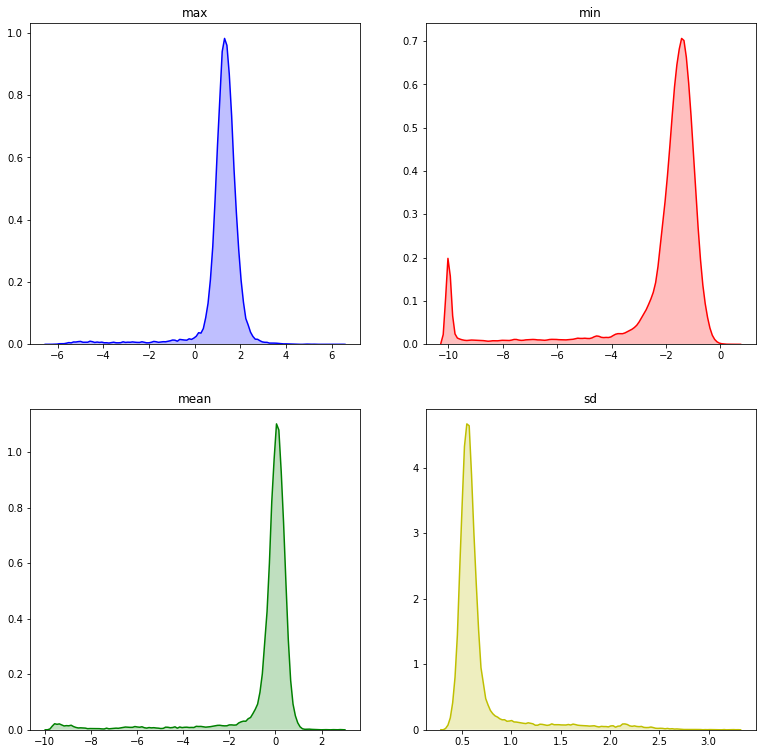

In [20]:
# some stats plot for cell viability. Find distribution of max/min/mean/std across all cell columns. 
fig, axs = plt.subplots(ncols=2 , nrows = 2 , figsize=(13,13))
sns.distplot(df_train[cells].max(axis =1) ,color="b",hist=False, kde_kws={"shade": True}, ax=axs[0][0] ).set(title = 'max')
sns.distplot(df_train[cells].min(axis =1) ,color="r",hist=False, kde_kws={"shade": True}, ax=axs[0][1] ).set(title = 'min')
sns.distplot(df_train[cells].mean(axis =1), color="g",hist=False, kde_kws={"shade": True}, ax=axs[1][0] ).set(title = 'mean')
sns.distplot(df_train[cells].std(axis =1) ,color="y",hist=False, kde_kws={"shade": True}, ax=axs[1][1] ).set(title = 'sd')
plt.show()

Max seems concentrated. On the other hand min is mostly concentrated but jumps at -10.

# 1.4 ANALYZING TARGET VARIABLE
All the targets are binary columns, indicating whether a certain cell type responds to the drug, or not. Some target classes also measure the type of response; e.g. there is an adrenergic_receptor_agonist class and an adrenergic_receptor_antagonist class. Those should probably not be active for the same sample row.

Our challenge is a multi-label classification problem, and as such the rows (i.e. drug samples) can have multiple MoA’s (i.e. more than one target class can be active). We will first look at the distribution of how many target classes can be active at once.

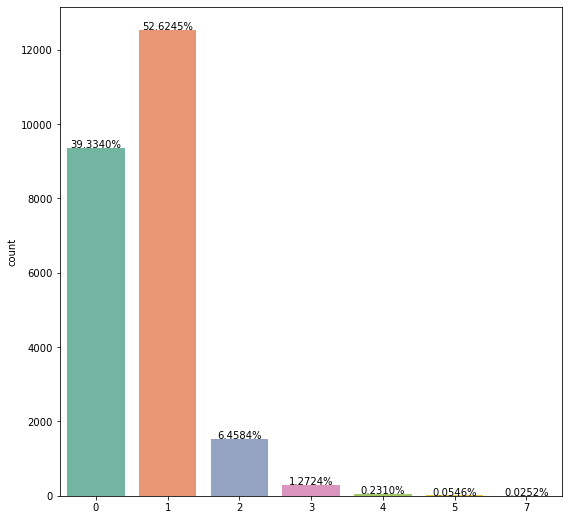

In [21]:
target  = df_train_scored.drop(['sig_id'] , axis =1)

fig, ax = plt.subplots(figsize=(9,9))
ax = sns.countplot(target.sum(axis =1), palette="Set2")
total = float(len(target))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.4f}%'.format((height/total)*100),
            ha="center") 

plt.show()

1. About 39% have no Moa annotations. It was expexcted to be a sparse data and since 40% are completly empty this verifies our assumptions.
2. For more than 1 MoA annotation, we see a tail that extends down to 7 simultaneous MoAs (for 0.03% of cases)
3. Majority of the cases have single annotation about 52% cases

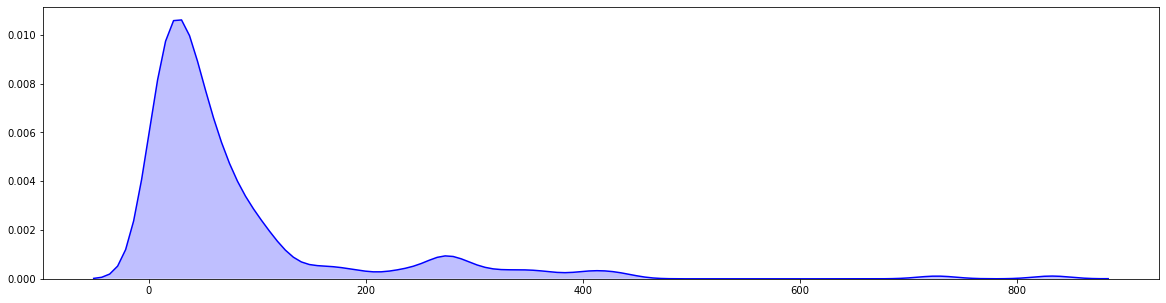

In [22]:
## counts per target class- 
sns.kdeplot(target.sum() , shade = True , color = "b")

Note that most target variables have under 200 occurrences. Recall that we have 206 target variables (206 classes), and 23814 observations.

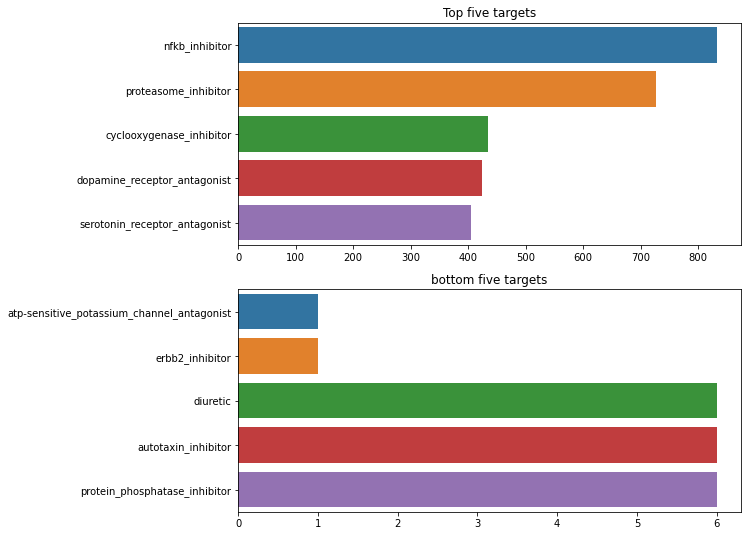

In [23]:
top_targets = pd.Series(target.sum()).sort_values(ascending=False)[:5]
bottom_targets = pd.Series(target.sum()).sort_values()[:5]
fig, axs = plt.subplots(figsize=(9,9) , nrows=2)
sns.barplot(top_targets.values , top_targets.index , ax = axs[0] ).set(title = "Top five targets")
sns.barplot(bottom_targets.values , bottom_targets.index, ax = axs[1] ).set(title = "bottom five targets")
plt.show()

There are two cases with only one anotation
The top target seems to be around 800 (nfkb-inhibitor) also terms like inhibitor antagonist seem to repeat with different suffixes. We can dig into that and try to find patterns between inhibitors etc...

We will now see target distribution based on prefixes separated by '_'

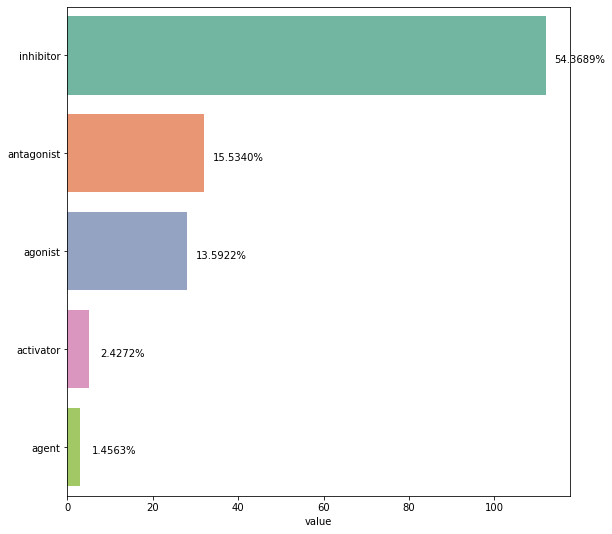

In [24]:
cols = pd.DataFrame({'value': [1 for i in list(target) ]} , index = [i.split('_')[-1] for i in list(target)] )
cols_top_5 = cols.groupby(level=0).sum().sort_values(by = 'value' , ascending = False)[:5]

fig, ax = plt.subplots(figsize=(9,9))

sns.barplot(x = cols_top_5.value , y = cols_top_5.index , palette="Set2" , orient='h')


for p in ax.patches:
    width = p.get_width()
    plt.text(8+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.4f}%'.format((width /206 )*100), # total 206 columns
             ha='center', va='center')

plt.show()

As we can see, most of our targets are inhibitors.

In [25]:
print("Top five suffixes constitue for about ", list(cols_top_5.sum()/cols.sum().values)[0]*100 , "%")

Top five suffixes constitue for about  87.37864077669903 %


# BIVARIATE ANALYSIS

Comparing common variables(cp_type , cp_dose and cp_time)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


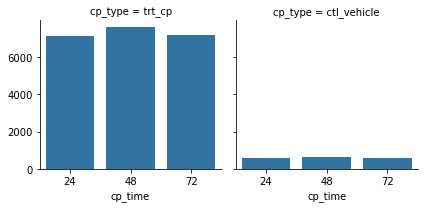

In [26]:
g  = sns.FacetGrid(df_train, col="cp_type" )
g.map(sns.countplot , 'cp_time'  )
plt.show()

# sns.countplot(x = features['cp_time']  )

ctrl_vehicle is as expected way less than trt_cp 

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


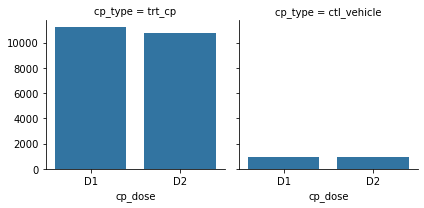

In [27]:
g  = sns.FacetGrid(df_train, col="cp_type" )
g.map(sns.countplot , 'cp_dose'  )
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


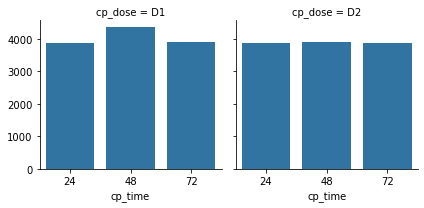

In [28]:
g  = sns.FacetGrid(df_train, col="cp_dose" )
g.map(sns.countplot , 'cp_time'  )
plt.show()

Slight difference between D1 (low dose) administered for 48 hours compared to the rest. 

# Gene Expression vs Common Variables

In the following code, we will find the mean of gene expression data for each gene and plot a histogram for each category of each common feature (cp_type, cp_time, cp_dose)

In [29]:
# g_mean and  c_mean and g_mean for analysis.
df_train['c_mean'] = df_train[cells].mean(axis =1)
df_train['g_mean'] = df_train[genes].mean(axis =1)

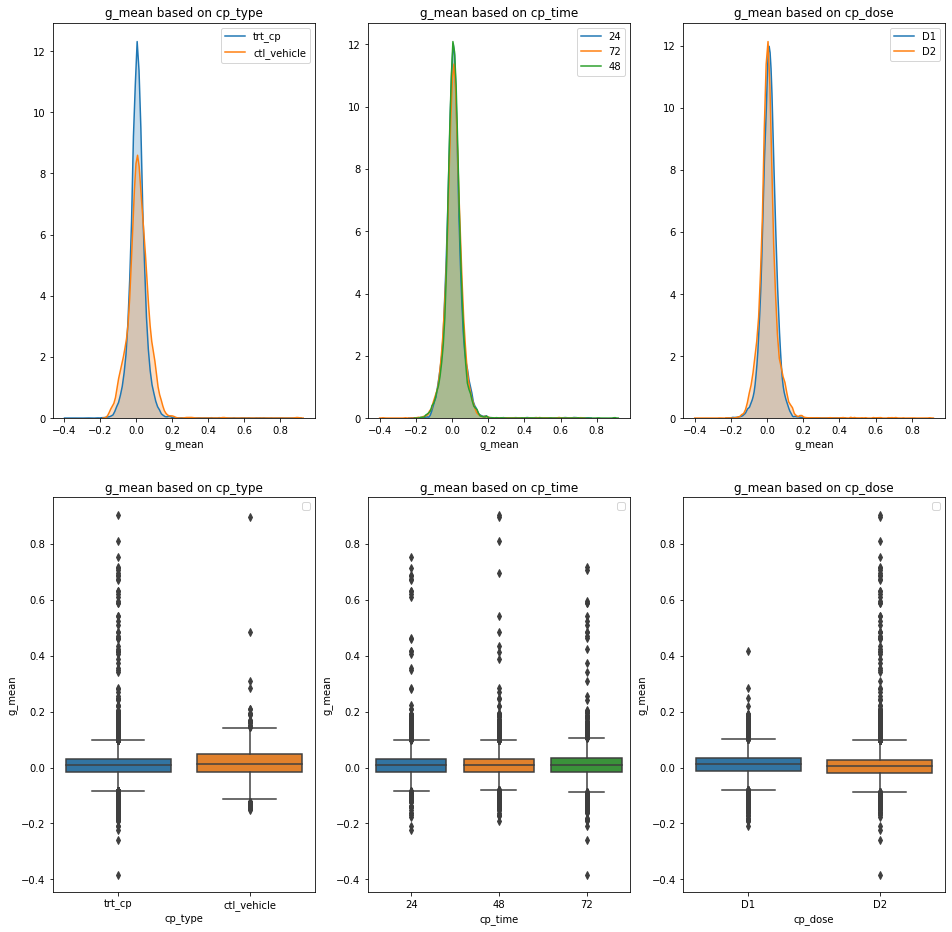

In [30]:
fig, axs = plt.subplots(figsize=(16,16) , nrows=2 , ncols =3)
plt.subplot(231)
for i in df_train.cp_type.unique():
    sns.distplot(df_train[df_train['cp_type']==i]['g_mean'],label=i, hist=False, kde_kws={"shade": True})
plt.title(f"g_mean based on cp_type")
plt.legend()

plt.subplot(232)
for i in df_train.cp_time.unique():
    sns.distplot(df_train[df_train['cp_time']==i]['g_mean'],label=i, hist=False, kde_kws={"shade": True})
plt.title(f"g_mean based on cp_time")
plt.legend()

plt.subplot(233)
for i in df_train.cp_dose.unique():
    sns.distplot(df_train[df_train['cp_dose']==i]['g_mean'],label=i, hist=False, kde_kws={"shade": True})
plt.title(f"g_mean based on cp_dose")
plt.legend()

plt.subplot(234)
sns.boxplot( x = df_train['cp_type'] , y = df_train['g_mean'] )
plt.title(f"g_mean based on cp_type")
plt.legend()

plt.subplot(235)
sns.boxplot( x = df_train['cp_time'] , y = df_train['g_mean'] )
plt.title(f"g_mean based on cp_time")
plt.legend()

plt.subplot(236)
sns.boxplot( x = df_train['cp_dose'] , y = df_train['g_mean'] )
plt.title(f"g_mean based on cp_dose")
plt.legend()

plt.show()

As seen in univariate analysis for cells and genes cells have negative tail and genes have a positive tail.

The distribution on the basis of common vars are similar with slight diffrence in negative(extreme) values for cells and positive (extreme) values for genes

In [31]:
# RobustScalar transforms the feature vector by subtracting the median and then dividing by the interquartile range (25% - 75%)
#note: id column is dropped here
df_copy = df_train.copy(deep=True)
df_id = df_train["sig_id"]
df_copy.drop("sig_id", axis = 1, inplace = True)
df_copy['cp_type'] = df_copy['cp_type'].apply(lambda x: 1 if x == "ctl_vehicle" else 0)
df_copy['cp_dose'] = df_copy['cp_dose'].apply(lambda x: 1 if x == "D2" else 0)
scaler = RobustScaler()
X = df_copy.values
X = scaler.fit_transform(X)

df_X = pd.DataFrame(X, columns=df_copy.columns)

# Cell Viability vs Common Variables

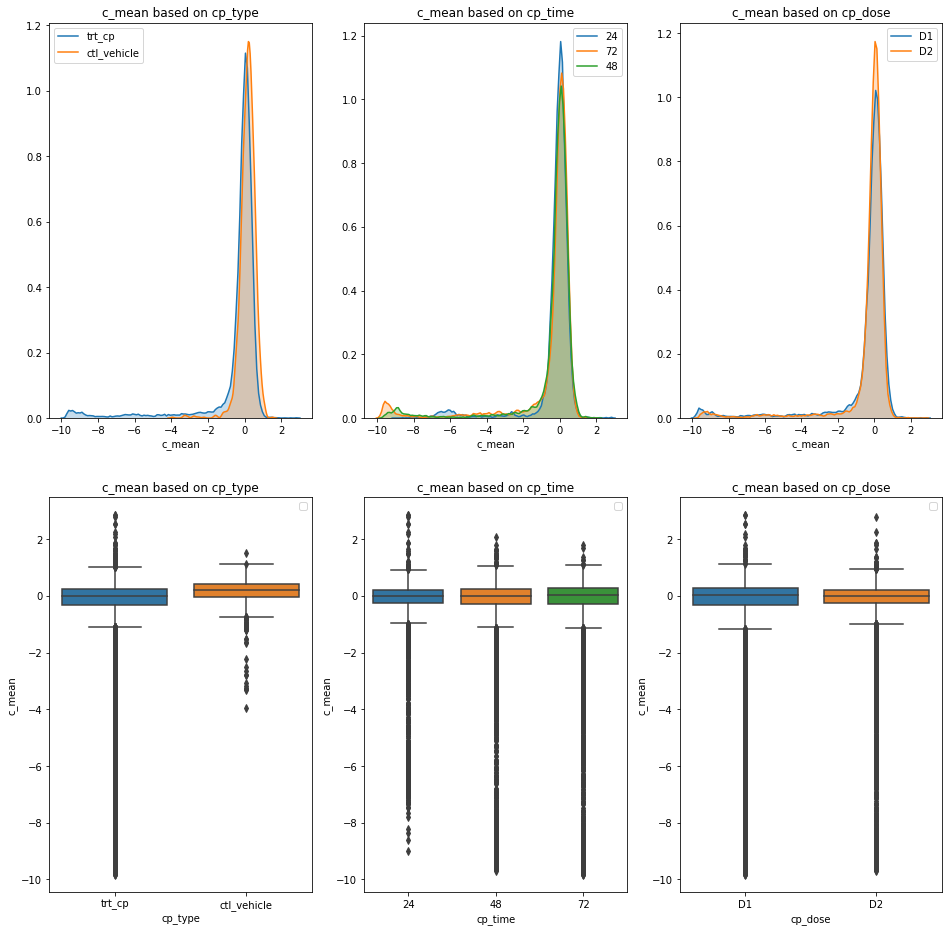

In [32]:
features = df_train
fig, axs = plt.subplots(figsize=(16,16) , nrows=2 , ncols =3)
plt.subplot(231)
for i in features.cp_type.unique():
    sns.distplot(features[features['cp_type']==i]['c_mean'],label=i, hist=False, kde_kws={"shade": True})
plt.title(f"c_mean based on cp_type")
plt.legend()

plt.subplot(232)
for i in features.cp_time.unique():
    sns.distplot(features[features['cp_time']==i]['c_mean'],label=i, hist=False, kde_kws={"shade": True})
plt.title(f"c_mean based on cp_time")
plt.legend()

plt.subplot(233)
for i in features.cp_dose.unique():
    sns.distplot(features[features['cp_dose']==i]['c_mean'],label=i, hist=False, kde_kws={"shade": True})
plt.title(f"c_mean based on cp_dose")
plt.legend()

plt.subplot(234)
sns.boxplot( x = features['cp_type'] , y = features['c_mean'] )
plt.title(f"c_mean based on cp_type")
plt.legend()

plt.subplot(235)
sns.boxplot( x = features['cp_time'] , y = features['c_mean'] )
plt.title(f"c_mean based on cp_time")
plt.legend()

plt.subplot(236)
sns.boxplot( x = features['cp_dose'] , y = features['c_mean'] )
plt.title(f"c_mean based on cp_dose")
plt.legend()

plt.show()

# Target Variables vs Common Variables

In [33]:
feat_target  = pd.merge(df_train , df_train_scored , how = "inner" , on = ['sig_id','sig_id'])
target_cols = list(target)
feat_target["target_sum"] = feat_target[target_cols].sum(axis =1)
feat_target.drop("sig_id" , axis = 1, inplace = True)

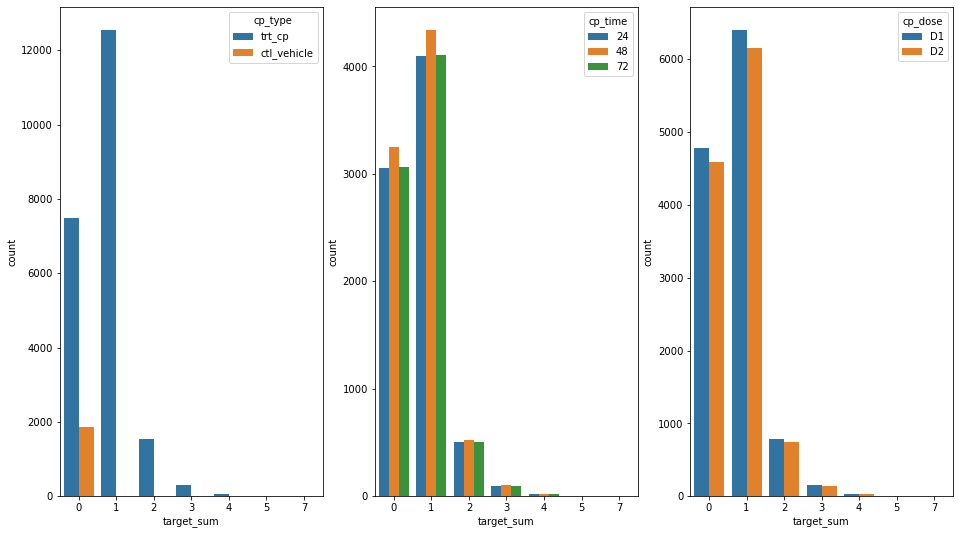

In [34]:
fig,ax = plt.subplots(figsize=(16,9))
plt.subplot(131)
sns.countplot(x = 'target_sum' , hue= 'cp_type', data = feat_target)
plt.subplot(132)
sns.countplot(x = 'target_sum' , hue= 'cp_time', data = feat_target)
plt.subplot(133)
sns.countplot(x = 'target_sum' , hue= 'cp_dose', data = feat_target)

plt.show()

Observations: 
1. Ctl vehicle has no target annotations (no positive response for any target variable).
2. Most of the observations have 1 target annotation.

# Target Variables vs G mean and C mean

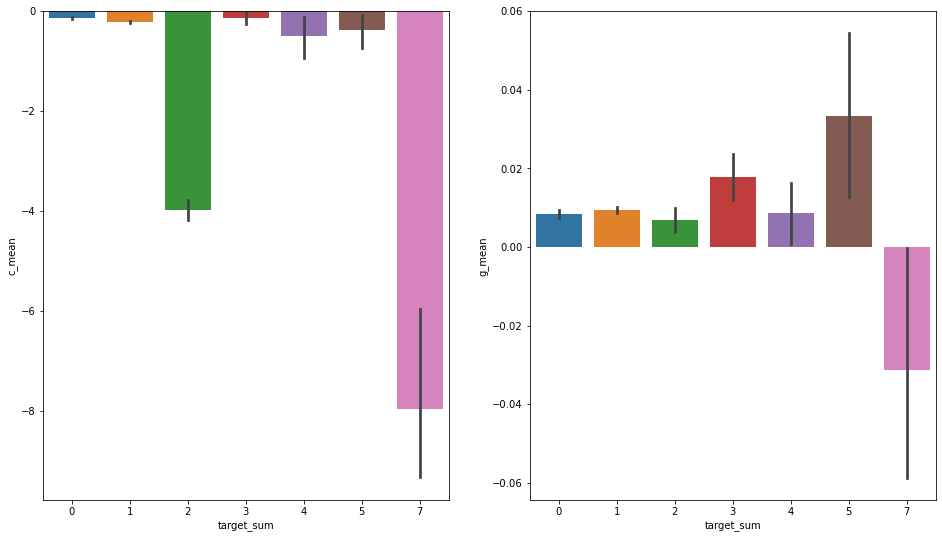

In [35]:
fig,ax = plt.subplots(figsize=(16,9))
plt.subplot(121)
sns.barplot(x = 'target_sum' , y= 'c_mean', data = feat_target)
plt.subplot(122)
sns.barplot(x = 'target_sum' , y= 'g_mean', data = feat_target)

plt.show()

Above requires further understanding

# Multivariate Analysis and Heatmaps

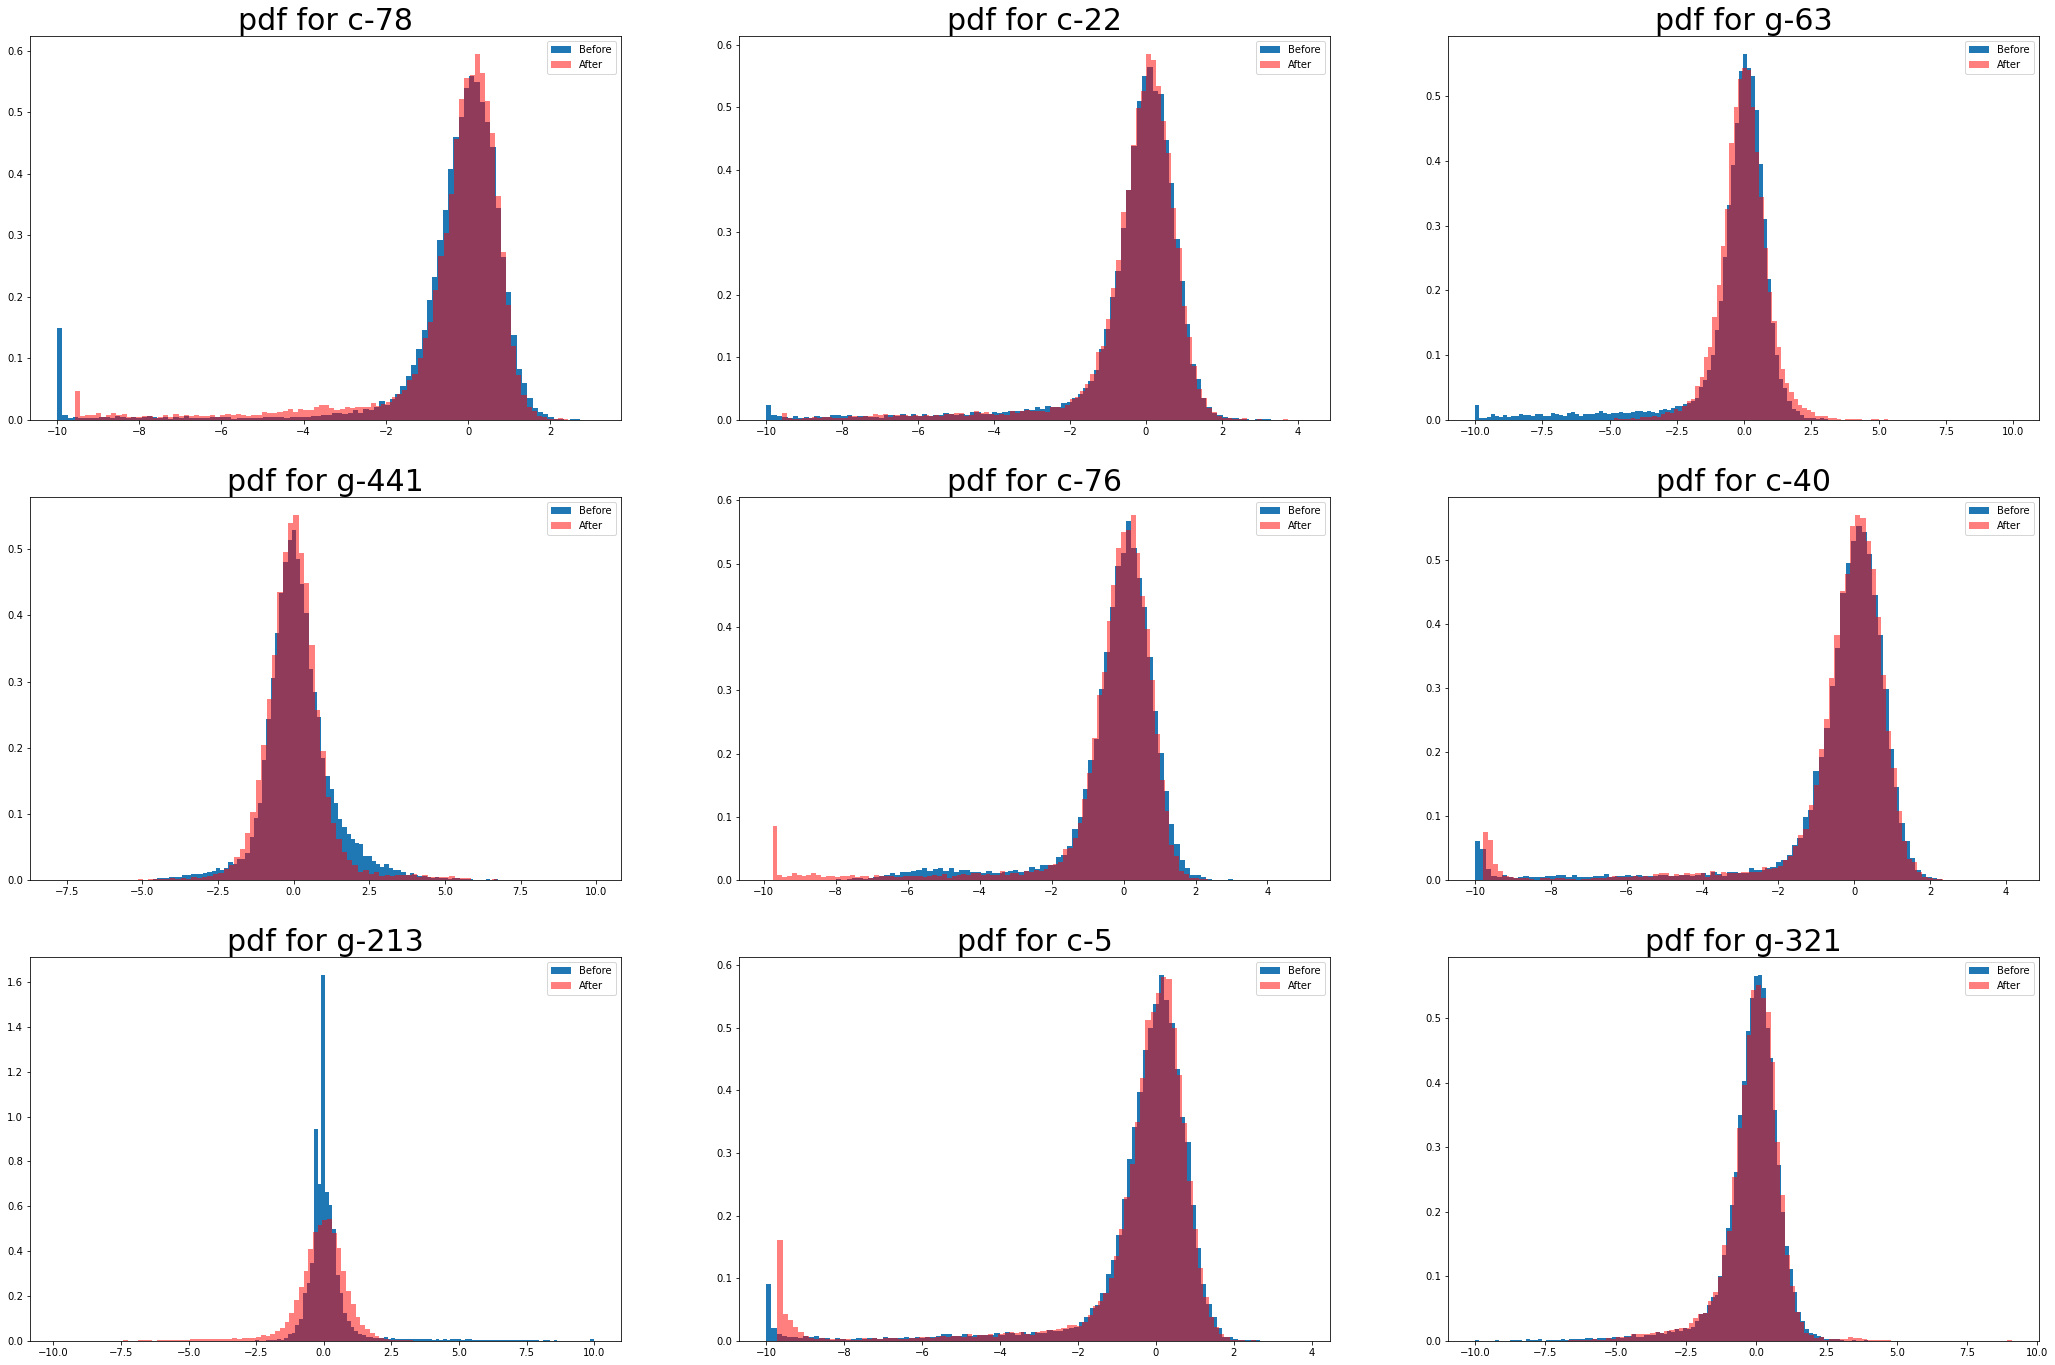

In [36]:
# New pdf for 9 random features
nrows, ncols = 3, 3

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[36,24])

for i in range(nrows):
    for j in range(ncols):
        axis = ax[i][j]
        feature = random.randint(0, 875)
        column_name = df_train.columns[feature]
        axis.hist(df_train.iloc[:, feature], density=True, bins=100)
        axis.hist(df_X.iloc[:, feature],density=True, bins=100, alpha=0.5, color='red')
        axis.set_title(f'pdf for {df_train.columns[feature]}', {'fontsize': 30})
        axis.legend(['Before', 'After'])

plt.show()